# 01 Work with Detectors

This notebook is all about how to get a detector to work with in simulation or data analysis. A detector can be generated by using a configuration. This configuration is loadable and saveable using the library [Pydantic](https://pydantic-docs.helpmanual.io/) which ensures solid typing, validation and serialization from and to json.

## Table of Contents

1. [Import Dependencies](#dependencies)
2. [Playing around with the configuration](#configuration)
3. [Creating a detector](#detector)
4. [Visualizing a detector](#visualization)

## Import dependencies <a class="anchor" id="dependencies"></a>

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import plotly.graph_objects as go

## Playing around with the Configuration <a class="anchor" id="configuration"></a>

The configuration is written in a way that its easy to persist and pass around. Like that a detector can be recreated easily using the configuration. Later on when generating multiple datasets, having this interoperability will be crucial in making knowledge transferable.

Each configuration contains four parts:
* **geometry:** Contains the details on the detector's geometry (e.g. triangular)
* **string:** Contains the details on the properties for each string
* **module:** Contains the details on the properties for each module
* **pmt:** Contains the details on the properties for each pmt

In addition, the property `seed` can be set to ensure all random processes within the detector generation, like setting PMT noise rates can be fixed. Let's look at some examples:

In [2]:
from ananke.configurations.detector import StringConfiguration, PMTConfiguration, ModuleConfiguration, \
    LengthGeometryConfiguration, DetectorConfiguration, DetectorGeometries

string_configuration = StringConfiguration(
    z_offset=50.0,
    module_number=20,
    module_distance=50.0
)

pmt_configuration = PMTConfiguration(
    efficiency= 0.4,
    noise_rate = 1e-6,
    gamma_scale = .25
)

module_configuration = ModuleConfiguration(
    radius=20
)

geometry_configuration = LengthGeometryConfiguration(
    type=DetectorGeometries.TRIANGULAR,
    side_length=100
)

detector_configuration = DetectorConfiguration(
    geometry=geometry_configuration,
    string=string_configuration,
    module=module_configuration,
    pmt=pmt_configuration,
    seed=1337
)

print(detector_configuration)

geometry=LengthGeometryConfiguration(start_position=Position(x=0.0, y=0.0), type=<DetectorGeometries.TRIANGULAR: 'triangular'>, side_length=100) string=StringConfiguration(z_offset=50.0, module_number=20, module_distance=50.0) module=ModuleConfiguration(radius=20.0, module_as_PMT=False) pmt=PMTConfiguration(efficiency=0.4, area=0.0375, noise_rate=1e-06, gamma_scale=0.25) seed=1337


Tha looks fantastic, does not it. Only problem is that you have to create quite a lot of classes. Meet the power of pydantic. We can just create a dict which could be read via json or yaml and go from there. Is not that fantastic? As I am lazy, you can as well check out some default values

In [82]:
configuration = {
    "string": {
        "module_number": 20,
        "module_distance": 50
    },
    "pmt": {
        "efficiency": 0.4
    },
    "module": {
        "radius": 15
    },
    "geometry": {
        "type": "triangular",
        "side_length": 100,
    },
    "seed": 4545
}

detector_configuration_dict = DetectorConfiguration.parse_obj(configuration)

print(detector_configuration_dict)

geometry=LengthGeometryConfiguration(start_position=Position(x=0.0, y=0.0), type=<DetectorGeometries.TRIANGULAR: 'triangular'>, side_length=100) string=StringConfiguration(z_offset=0.0, module_number=20, module_distance=50.0) module=ModuleConfiguration(radius=15.0, module_as_PMT=False) pmt=PMTConfiguration(efficiency=0.4, area=0.0375, noise_rate=0.00016, gamma_scale=0.0) seed=4545


And it gets even better. This is totally error proof (as long as the code is correct in typing). Let's check it out!

In [4]:
configuration = {
    "string": {
        "module_number": 20
    },
    "pmt": {
        "efficiency": 0.4
    },
    "module": {
        "radius": 15
    },
    "geometry": {
        "type": "triangular",
        "side_length": 100,
    },
    "seed": 4545
}

detector_configuration_err = DetectorConfiguration.parse_obj(configuration)

print(detector_configuration_err)

ValidationError: 1 validation error for DetectorConfiguration
string -> module_distance
  field required (type=value_error.missing)

In [5]:
configuration = {
    "string": {
        "module_number": "peter"
    },
    "pmt": {
        "efficiency": 5
    },
    "module": {
        "radius": -1
    },
    "geometry": {
        "type": "triangular",
        "number_of_strings_per_side": 45
    },
    "seed": 4545
}

detector_configuration_err = DetectorConfiguration.parse_obj(configuration)

ValidationError: 5 validation errors for DetectorConfiguration
geometry -> LengthGeometryConfiguration -> side_length
  field required (type=value_error.missing)
string -> module_number
  value is not a valid integer (type=type_error.integer)
string -> module_distance
  field required (type=value_error.missing)
module -> radius
  ensure this value is greater than 0 (type=value_error.number.not_gt; limit_value=0)
pmt -> efficiency
  ensure this value is less than or equal to 1 (type=value_error.number.not_le; limit_value=1)

Covering all possible errors here is impossible, but the idea should be clear right now.

## Creating a detector <a class="anchor" href="detector"></a>

Now we know how to handle the configurations. Let's create a detector. Wait for the magic:

In [99]:
from ananke.services.detector import DetectorBuilderService

configuration = {
    "string": {
        "module_number": 2,
        "module_distance": 10 # in m
    },
    "pmt": {
        "efficiency": 0.4 # between 0 and 1
    },
    "module": {
        "radius": 0.4 # in m
    },
    "geometry": {
        "type": "single",
        #"side_length": 100,
        #"number_of_strings_per_side": 3,
        #"distance_between_strings": 100.0
    },
    "seed": 4545
}

detector_configuration = DetectorConfiguration.parse_obj(configuration)

detector_service = DetectorBuilderService()

detector = detector_service.get(detector_configuration)

detector.df.head()

,string_location_x,string_location_y,string_location_z,string_id,module_id,module_location_x,module_location_y,module_location_z,module_radius,pmt_orientation_x,pmt_orientation_y,pmt_orientation_z,pmt_id,pmt_efficiency,pmt_area,pmt_noise_rate,pmt_location_x,pmt_location_y,pmt_location_z
0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.4,4.226183e-01,0.000000,-0.906308,0,0.4,0.0375,0.00016,1.690473e-01,0.000000,-0.362523
1,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.4,4.226183e-01,0.000000,0.906308,1,0.4,0.0375,0.00016,1.690473e-01,0.000000,0.362523
2,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.4,5.963678e-01,0.596368,-0.537300,2,0.4,0.0375,0.00016,2.385471e-01,0.238547,-0.214920
3,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.4,5.963678e-01,0.596368,0.537300,3,0.4,0.0375,0.00016,2.385471e-01,0.238547,0.214920
4,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.4,2.587791e-17,0.422618,-0.906308,4,0.4,0.0375,0.00016,1.035116e-17,0.169047,-0.362523


That is how easy it gets :) As a numpy array, we get an array containing all the modules/pmts positions with the ids for string, module and:

In [29]:
print(np.array(detector))

[[-2.00000000e+02 -2.00000000e+02  0.00000000e+00 ... -1.99830953e+02
  -2.00000000e+02 -3.62523115e-01]
 [-2.00000000e+02 -2.00000000e+02  0.00000000e+00 ... -1.99830953e+02
  -2.00000000e+02  3.62523115e-01]
 [-2.00000000e+02 -2.00000000e+02  0.00000000e+00 ... -1.99761453e+02
  -1.99761453e+02 -2.14919843e-01]
 ...
 [ 2.00000000e+02  2.00000000e+02  0.00000000e+00 ...  2.00000000e+02
   1.99830953e+02  9.50362523e+02]
 [ 2.00000000e+02  2.00000000e+02  0.00000000e+00 ...  2.00238547e+02
   1.99761453e+02  9.49785080e+02]
 [ 2.00000000e+02  2.00000000e+02  0.00000000e+00 ...  2.00238547e+02
   1.99761453e+02  9.50214920e+02]]


Let's see what we created:

In [100]:
from ananke.visualisation.detector import get_detector_scatter3ds

fig = get_detector_scatter3ds(detector, False, True, size=3)
#fig.write_image(configuration['geometry']['type'] + '_3d.png', scale=2)
fig

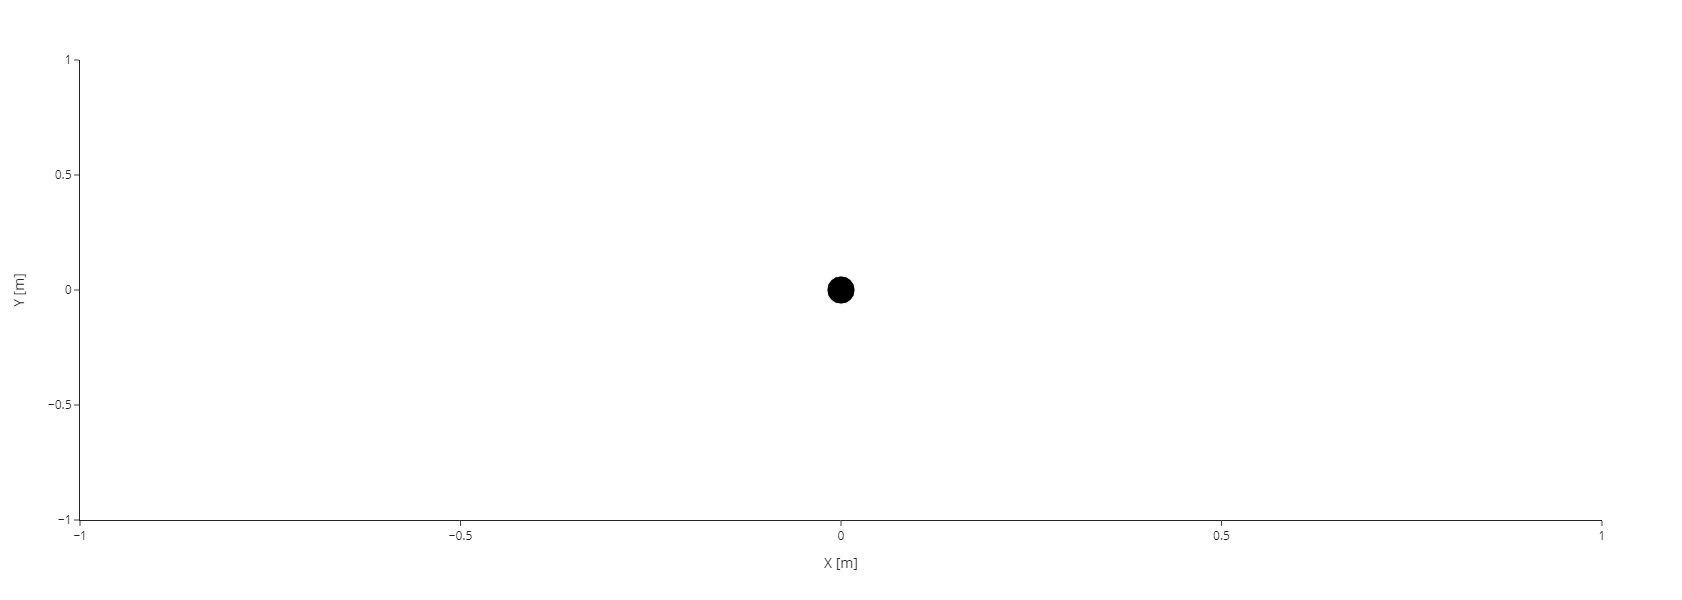

In [98]:
import plotly.express as px

string_locations = detector.string_locations.df[["x", "y"]].drop_duplicates()
string_locations['size'] = 5

fig = px.scatter(x=string_locations.to_numpy()[:,0], y=string_locations.to_numpy()[:,1], color_discrete_sequence=['black'], size=string_locations['size'], opacity=1,labels={
                     "x": "X [m]",
                     "y": "Y [m]"
                 })

camera = dict(
    eye=dict(x=1, y=2, z=0.1)
)

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    template='simple_white',
    scene=go.layout.Scene(
        xaxis=go.layout.scene.XAxis(title='x [m]'),
        yaxis=go.layout.scene.YAxis(title='y [m]')
    ),
    #plot_bgcolor= '#fff'
)
fig.write_image(configuration['geometry']['type'] + '_top.png', scale=2)
fig

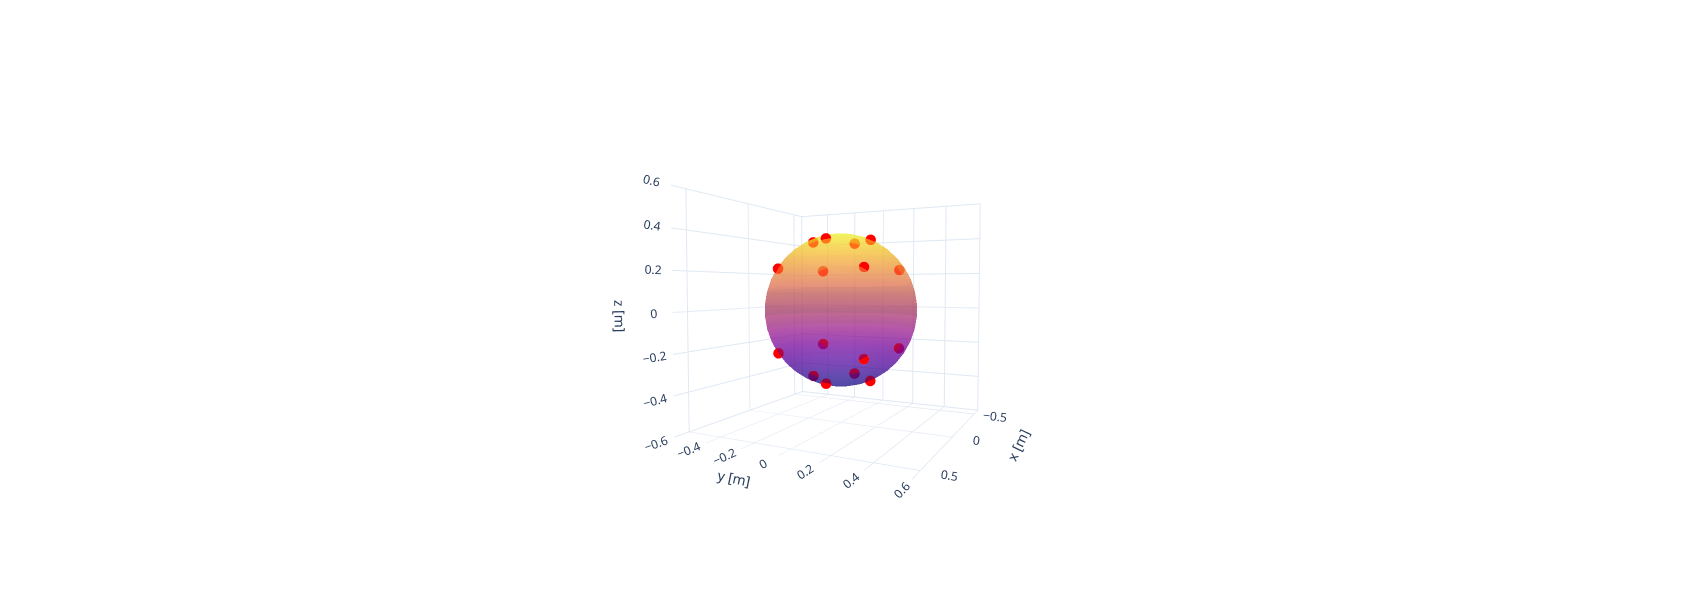

In [156]:
configuration2 = {
    "string": {
        "module_number": 1,
        "module_distance": 50
    },
    "pmt": {
        "efficiency": 0.4
    },
    "module": {
        "radius": 0.4
    },
    "geometry": {
        "type": "single",
        "side_length": 100,
    },
    "seed": 4545
}

detector_service2 = DetectorBuilderService()

detector_configuration2 = DetectorConfiguration.parse_obj(configuration2)

detector2 = detector_service2.get(detector_configuration2)


fig2 = go.Figure(
    data=[go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=.5, autocolorscale=False, showscale=False)] + get_detector_scatter3ds(detector2, True, False, size=6, pmt_opacity=1.0)
)

camera = dict(
    eye=dict(x=2, y=1, z=0.1)
)

def ms(x, y, z, radius, resolution=20):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

(x_pns_surface, y_pns_surface, z_pns_suraface) = ms(0, 0, 0, configuration2["module"]["radius"])

axis_range = [-1.5*configuration2["module"]["radius"],1.5*configuration2["module"]["radius"]]
fig2.update_layout(
    autosize=False,
    width=600,
    height=600,
    scene=go.layout.Scene(
        xaxis=go.layout.scene.XAxis(title='x [m]', range=axis_range),
        yaxis=go.layout.scene.YAxis(title='y [m]', range=axis_range),
        zaxis=go.layout.scene.ZAxis(title='z [m]', range=axis_range)
    ),
    scene_camera=camera,
    template='plotly_white'
)
fig2